In [1]:
# 使用jupyter notebook 要加：
%matplotlib inline

import requests
import pandas as pd
import json
import numpy as np
# conda install seaborn
import seaborn as sns
import crawl_price
import Sharpe_strategy


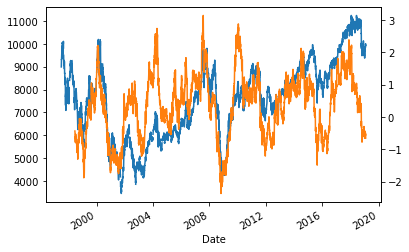

In [3]:
d_252=252
d_60=60
# 1. 下載台股大盤資料
twii = crawl_price.crawl_price('^TWII')

# 2. 編寫台股的sharpe ratio
mean = twii['close'].pct_change().rolling(d_252).mean()
std = twii['close'].pct_change().rolling(d_252).std()
sharpe = mean / std *(d_252**0.5)
twii.close.plot()
sharpe.plot(secondary_y=True)


In [4]:
Sharpe_strategy.Search(twii)



6.123058723589804 40 0.5699999999999997 0.06 40


In [61]:
# 3. 編寫台股sharpe ratio策略

# sharpe ratio 平滑
sr = sharpe
srsma = sr.rolling(d_60).mean()

# sharpe ratio 的斜率
srsmadiff = srsma.diff()

# 計算買入賣出點
buy = (srsmadiff > 0) & (srsmadiff.shift() < 0)
sell = (srsmadiff < 0) & (srsmadiff.shift() > 0)

# 計算持有時間
hold = pd.Series(np.nan, index=buy.index)
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
# hold.plot()

# 持有時候的績效
adj = twii['close'][buy.index]
(adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()

# test=(adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod()
# print(test)
# print(test.iloc[-1])
# print(adj)
# print(hold==1)
# print(adj[hold==1])


Date
1998-09-21    1.000653
1998-09-22    0.990436
1998-09-23    0.992965
1998-09-24    0.992957
1998-09-25    0.983101
                ...   
2019-01-22    2.661060
2019-01-23    2.669362
2019-01-24    2.694358
2019-01-25    2.706174
2019-01-28    2.684083
Name: close, Length: 2591, dtype: float64
2.684082629800936


In [65]:
# 回傳投資組合下的報酬率
def backtest(a, b, c, d):
    sr = sharpe
    srsma = sr.rolling(a).mean()

    srsmadiff = srsma.diff() * 100
    ub = srsmadiff.quantile(b)
    lb = srsmadiff.quantile(c)
    
    # srsmadiff.shift(d)代表幾天前的夏普
    buy = ((srsmadiff.shift(d) < lb) & (srsmadiff > ub))
    sell = ((srsmadiff.shift(d) > ub) & (srsmadiff < lb))

    hold = pd.Series(np.nan, index=buy.index)
    hold[buy] = 1
    hold[sell] = 0

    hold.ffill(inplace=True)
    
    adj = twii['close'][buy.index]

    # eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()
    # hold.plot()
    eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod()
    if len(eq) > 0:
        return eq.iloc[-1]
    else:
        return 1

# 暴力搜尋
maxeq = 0
ma_smooth=0
negative_sign=0
positive_sign=0
detect_lag=0
for a in range(100,200,20):
    for b in np.arange(0.3, 0.9, 0.03):
        for c in np.arange(0.3, 0.6, 0.03):
            for d in range(60, 180, 10): 
                eq = backtest(a,b,c,d)
                if maxeq < eq:
                    maxeq = eq
                    ma_smooth=a
                    negative_sign=b
                    positive_sign=c
                    detect_lag=d
                    print(eq,ma_smooth,negative_sign,positive_sign,detect_lag)

1.2071208957939294 120 0.7799999999999996 0.3899999999999999 140


4.544042274028518


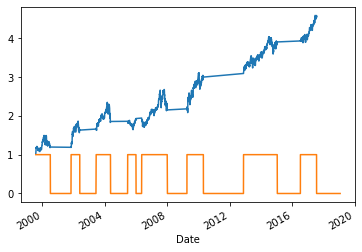

In [70]:
# 畫投資組合的圖+最大報酬
def backtest_plot(a, b, c, d):
    sr = sharpe
    srsma = sr.rolling(a).mean()

    srsmadiff = srsma.diff() * 100
    ub = srsmadiff.quantile(b)
    lb = srsmadiff.quantile(c)
    
    # srsmadiff.shift(d)代表幾天前的夏普
    buy = ((srsmadiff.shift(d) < lb) & (srsmadiff > ub))
    sell = ((srsmadiff.shift(d) > ub) & (srsmadiff < lb))

    hold = pd.Series(np.nan, index=buy.index)
    hold[buy] = 1
    hold[sell] = 0

    hold.ffill(inplace=True)
    adj = twii['close'][buy.index]
    eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod()
    eq.plot()
    hold.plot()

    print(eq.iloc[-1])
backtest_plot(ma_smooth,negative_sign,positive_sign,detect_lag)
